In [32]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [33]:
train=pd.read_csv(r"C:\Users\admin\Desktop\Project\data\台北一\蔬果\奇異果-進口.csv")
weather=pd.read_csv(r"C:\Users\admin\Desktop\Project\data\台北一\氣象資料\氣象資料.csv")
weather=weather.drop(["Unnamed: 0"], axis=1)
weather=weather.drop(["一小時最大降水量(mm)"], axis=1)
weather=weather.drop(["10分鐘最大降水起始時間(LST)"], axis=1)
weather=weather.drop(["10分鐘最大降水量(mm)"], axis=1)
weather=weather.drop([" 一小時最大降水量(mm)"], axis=1)
weather=weather.drop(["一小時最大降水量起始時間(LST)"], axis=1)
weather=weather.drop(["日最高紫外線指數時間(LST)"], axis=1)
weather=weather.drop(["最低氣溫時間(LST)"], axis=1)
weather=weather.drop(["最大陣風風速時間(LST)"], axis=1)
weather=weather.drop(["最小相對溼度時間(LST)"], axis=1)
weather=weather.drop(["最高氣溫時間(LST)"], axis=1)
weather=weather.drop(["測站最低氣壓時間(LST)"], axis=1)
weather=weather.drop(["測站最高氣壓時間(LST)"], axis=1)
weather=weather.drop(["降水量(mm)"], axis=1)
weather=weather.drop(["日最高紫外線指數"], axis=1)
weather=weather.drop(["A型蒸發量(mm)"], axis=1)

a=0
b=0
c=weather.shape[0]
d=0
for i in range(0,train.shape[0]):
    for j in range(a,c-d):
        if all([train["year"][i]==weather["year"][j] , train["month"][i]==weather["month"][j] , train["day"][i]==weather["day"][j]]):
            weather=weather.drop(weather.index[a:b+a])
            weather.reset_index(inplace=True)
            weather=weather.drop(["index"], axis=1)
            a=a+1
            b=0
            break
        else:
            b=b+1
            d=d+1
weather=weather.drop(weather.index[train.shape[0]:])
weather.reset_index(inplace=True)
weather=weather.drop(["index"], axis=1)
train=pd.concat([train,weather],axis=1)


In [34]:
print(train)
train.to_csv("test1.csv", encoding='utf_8_sig')

      Unnamed: 0 crop_name crop_num   high   low market_name  market_num  \
0              0    奇異果-進口      G49   72.5  60.3         台北一         109   
1              1    奇異果-進口      G49   88.9  41.5         台北一         109   
2              2    奇異果-進口      G49   89.2  65.1         台北一         109   
3              3    奇異果-進口      G49   98.4  55.2         台北一         109   
4              4    奇異果-進口      G49   82.8  28.5         台北一         109   
5              5    奇異果-進口      G49   89.7  41.4         台北一         109   
6              6    奇異果-進口      G49   91.4  58.1         台北一         109   
7              7    奇異果-進口      G49   88.9  53.2         台北一         109   
8              8    奇異果-進口      G49   87.3  66.4         台北一         109   
9              9    奇異果-進口      G49   84.8  61.4         台北一         109   
10            10    奇異果-進口      G49  101.7  32.8         台北一         109   
11            11    奇異果-進口      G49   94.2  58.8         台北一         109   
12          

In [35]:
def buildTrain(train, pastDay=1, futureDay=1):
    X_train, Y_train ,Z_train= [], [],[]
    for i in range(train.shape[0]-futureDay-pastDay+1):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["high"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay+futureDay-1]["high"]))
    return np.array(X_train), np.array(Y_train), np.array(Z_train)
def shuffle(X,Y,Z):
    np.random.seed()
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList],Z[randomList]
def splitData(X,Y,Z,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    Z_val = Z[:int(Z.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val,Z_val

In [36]:
train=train.drop(["Unnamed: 0"], axis=1)
train=train.drop(["crop_name"], axis=1)
train=train.drop(["crop_num"], axis=1)
train=train.drop(["market_name"], axis=1)
train=train.drop(["market_num"], axis=1)
train=train.convert_objects(convert_numeric=True)
temp=train

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [37]:
print(train)

       high   low  mean  medium  volume  year  month  day  dayofweek  day  \
0      72.5  60.3  66.6    66.7  2282.0  2012      1    1          6    1   
1      88.9  41.5  66.1    66.7  2235.0  2012      1    3          1    3   
2      89.2  65.1  70.8    66.7  2135.0  2012      1    4          2    4   
3      98.4  55.2  71.9    68.7  1054.0  2012      1    5          3    5   
4      82.8  28.5  58.2    60.0  2465.0  2012      1    6          4    6   
5      89.7  41.4  66.2    66.7  3464.0  2012      1    7          5    7   
6      91.4  58.1  70.1    67.0  3219.0  2012      1    8          6    8   
7      88.9  53.2  68.7    67.2  3815.0  2012      1   10          1   10   
8      87.3  66.4  70.7    66.7  2749.0  2012      1   11          2   11   
9      84.8  61.4  69.2    66.7  2994.0  2012      1   12          3   12   
10    101.7  32.8  67.6    67.8  1326.0  2012      1   13          4   13   
11     94.2  58.8  72.1    69.2  2650.0  2012      1   14          5   14   

In [38]:
train= train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
train_x1,train_y1,train_z1=buildTrain(train)
train_x2,train_y2,train_z2=buildTrain(temp)
train_x,train_y,train_z=train_x1,train_y2,train_z2
train_x,train_y,train_z= shuffle(train_x,train_y,train_z)
train_x,train_y, val_x, val_y ,val_z= splitData(train_x,train_y,train_z, 0.1)
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(val_z.shape)

(1925, 1, 32)
(1925, 1)
(213, 1, 32)
(213, 1)
(213, 1)


In [41]:
model = Sequential()
model.add(LSTM(100, input_length=train_x.shape[1],input_dim= train_x.shape[2],return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x,train_y, epochs=300, batch_size=8, validation_split=0.1, callbacks=[callback])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=True, input_shape=(1, 32))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 100)            53200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 133,701
Trainable params: 133,701
Non-trainable params: 0
_________________________________________________________________
Trai

1732/1732 [==============================] - 1s 409us/step - loss: 924.9548 - val_loss: 756.7623
Epoch 65/300
1732/1732 [==============================] - 1s 413us/step - loss: 907.4813 - val_loss: 757.2737
Epoch 66/300
1732/1732 [==============================] - 1s 412us/step - loss: 894.7157 - val_loss: 758.9676
Epoch 67/300
1732/1732 [==============================] - 1s 432us/step - loss: 905.7835 - val_loss: 764.8627
Epoch 00067: early stopping


accuracy:61.502347417840376%


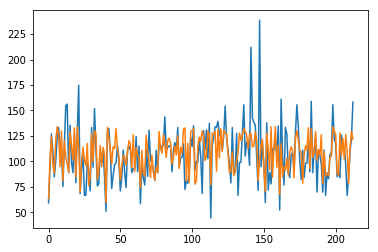

In [42]:
a=range(0,val_y.shape[0])
val_y=val_y.reshape(-1)
val_z=val_z.reshape(-1)
plt.plot(a,val_y)
b=[]
co=0
for i in range(0,val_x.shape[0]):
    temp=val_x[i]
    temp=temp.reshape(1,1,32)
    z=model.predict(temp, verbose=0)
    if val_y[i]>=val_z[i] and z>=val_z[i]:
        co=co+1
    if val_y[i]<val_z[i] and z<val_z[i]:
        co=co+1
    b.append(z)
b=np.array(b)
b=b.reshape(-1)
plt.plot(a,b)
acc=100*(co/val_x.shape[0])
print("accuracy:"+str(acc)+"%")
plt.show()